In [1]:
import pandas as pd
import pyarrow.dataset as pads
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Data Preparation

In [2]:
# For the data_path argument, include the full file path to the folder that holds the data!    
def readDataSubset(table_type, data_path="~/Desktop/SMT-Data-Challenge-2025-Updated"):
    if table_type not in ['ball_pos', 'game_events', 'game_info', 'player_pos', 'rosters']:
        print("Invalid data subset name. Please try again with a valid data subset.")
        return -1

    if table_type == 'rosters':
        return pads.dataset(source = os.path.join(os.path.dirname(__name__), 
                                                  data_path, 'rosters.csv'), format = 'csv')
    else:
        return pads.dataset(source = os.path.join(os.path.dirname(__name__), 
                                                  data_path, table_type),
                            format = 'csv', partitioning = ['home_team', 'away_team', 'year', 'day'])


In [3]:
# For mapping out true values for player position and game events

player_position_dict = {0:'no play',1: 'pitcher', 2: 'catcher', 3: 'first baseman', 
                        4: 'second baseman', 5: 'third baseman', 6: 'shortstop',
                        7: 'left field', 8: 'center field', 9: 'right field', 10: 'batter', 
                        11: 'runner on first base', 12: 'runner on second base', 13: 'runner on third base', 
                        255: 'ball event with no player (e.g., ball bounce)', 14: 'home plate umpire', 
                        15: 'field umpire', 16: 'field umpire', 17: 'field umpire', 18: 'first vase coach', 
                        19:'third base coach'}

event_code_dict = {1: 'pitch', 2: 'ball acquired', 3: 'throw (ball-in-play)', 
                   4: 'ball hit into play', 5: 'end of play', 6:' pickoff throw',
                   7: 'ball acquired - unkonwn field position', 
                   8: 'throw (ball-in-play)-unkonwn field position', 
                   9: 'ball deflection', 10: 'ball deflection off of wall',
                     11: 'home run', 16: 'ball bounce'}

In [4]:
# Adding a home/away and year/day column
def column_adder(df):
    """
    - Adds 'year', 'day', 'home_team', and 'away_team' columns to the DataFrame based on patterns in 'game_str'.
    - Assumes 'game_str' includes year (yYYYY), day (dDDDD), and team codes (AAA_BBB).

    Parameters:
        df (pd.DataFrame): DataFrame with a 'game_str' column.
    Returns:
        pd.DataFrame: Updated DataFrame with extracted columns
    """
    # Extract year and day from 'game_str'
    df['year'] = df['game_str'].str.extract(r'y(\d+)').astype(int)
    df['day'] = df['game_str'].str.extract(r'd(\d+)').astype(int)

   # Add home and away team columns if not already present
    if 'home_team' not in df.columns:
        df[['away_team', 'home_team']] = df['game_str'].str.extract(r'_(\w{3})_(\w{3})$')

    df['home_team'] = df['home_team'].astype('category')
    df['away_team'] = df['away_team'].astype('category')

    return df

### Game Events 

In [5]:
def main():
    rosters_df = readDataSubset('game_events')
    full_df = rosters_df.to_table(columns=['game_str', 'play_id', 'at_bat',
                                           'play_per_game', 'timestamp',
                                           'player_position', 'event_code']
                                  ).to_pandas()

    return full_df  
    
if __name__ == "__main__":
    game_events_df = main()  

game_events_df['player_position'] = game_events_df['player_position'].map(player_position_dict)
game_events_df['event_code'] = game_events_df['event_code'].map(event_code_dict)

# Year column
game_events_df['year'] = game_events_df['game_str'].str.extract(r'y(\d+)')
game_events_df['year'] = game_events_df['year'].astype(int)

# Adding a home/away and year/day column
game_events_df = column_adder(game_events_df)

# Changing the data types to their correct/appropriate type
game_events_df['player_position'] = game_events_df['player_position'].astype('category')
game_events_df['event_code'] = game_events_df['event_code'].astype('category')

game_events_df.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,year,day,away_team,home_team
0,y1_d069_ACN_QEA,1,1,1,14853,pitcher,pitch,1,69,ACN,QEA
1,y1_d069_ACN_QEA,1,1,1,15303,catcher,ball acquired,1,69,ACN,QEA
2,y1_d069_ACN_QEA,1,1,1,15303,no play,end of play,1,69,ACN,QEA
3,y1_d069_ACN_QEA,2,1,2,27753,pitcher,pitch,1,69,ACN,QEA
4,y1_d069_ACN_QEA,2,1,2,28253,catcher,ball acquired,1,69,ACN,QEA


### Ball Position

In [6]:
def main():
    rosters_df = readDataSubset('ball_pos')

    full_df = rosters_df.to_table(columns=['game_str', 'play_id','timestamp', 'ball_position_x', 
                                           'ball_position_y', 'ball_position_z'
                                          ]).to_pandas()
    return full_df  

if __name__ == "__main__":
    ball_pos_df = main()

# Adding a home/away and year/day column
ball_pos_df = column_adder(ball_pos_df)

ball_pos_df.head()

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z,year,day,away_team,home_team
0,y1_d069_ACN_QEA,1,14853,3.500460,52.04430,5.71419,1,69,ACN,QEA
1,y1_d069_ACN_QEA,1,14903,3.210720,45.69720,5.54322,1,69,ACN,QEA
2,y1_d069_ACN_QEA,1,14953,2.929950,39.41790,5.31909,1,69,ACN,QEA
3,y1_d069_ACN_QEA,1,15003,2.658168,33.20670,5.04180,1,69,ACN,QEA
4,y1_d069_ACN_QEA,1,15053,2.395365,27.06366,4.71132,1,69,ACN,QEA


### Game Info

In [7]:
def main():
    rosters_df = readDataSubset('game_info')

    full_df = rosters_df.to_table(columns=['game_str', 'home_team','away_team', 
                                           'play_per_game', 'top_bottom_inning', 
                                           'pitcher', 'batter']).to_pandas()
    return full_df  

if __name__ == "__main__":
    game_info_df = main()

# Adding a home/away and year/day column
game_info_df = column_adder(game_info_df)

game_info_df.head()

,game_str,home_team,away_team,play_per_game,top_bottom_inning,pitcher,batter,year,day
0,y1_d069_ACN_QEA,QEA,ACN,1.0,top,QEA-0410,ACN-2455,1,69
1,y1_d069_ACN_QEA,QEA,ACN,2.0,top,QEA-0410,ACN-2455,1,69
2,y1_d069_ACN_QEA,QEA,ACN,3.0,top,QEA-0410,ACN-2455,1,69
3,y1_d069_ACN_QEA,QEA,ACN,4.0,top,QEA-0410,ACN-1416,1,69
4,y1_d069_ACN_QEA,QEA,ACN,134.0,top,QEA-0410,ACN-1147,1,69


# Finding Pitching Speed Per Player

### Pitching_speed_df
Creating a dataframe to calculate the speed of the pitching of the players

In [8]:
# MERGING DATA OF BALL POSITION AND GAME EVENTS/GAME INFO
pitching_speed_raw = pd.merge(game_events_df, ball_pos_df, on=["game_str", 'play_id', 'timestamp',
                                                              'year', 'day',
                                                              'away_team', 'home_team'], how='outer')
pitching_speed_raw = pd.merge(pitching_speed_raw, game_info_df, on=["game_str", 'game_str', 'home_team',
                                                                  'away_team', 'day','year', 'play_per_game'])
pitching_speed_raw = pitching_speed_raw.dropna()

In [9]:
# Creating a Foul Ball Counters
pitching_speed_raw['foul_ball'] = False

# Make sure index is reset so .loc[i] works with integer index
pitching_speed_raw = pitching_speed_raw.reset_index(drop=True)

# Define sequence to match
sequence_for_foul_ball = ["pitch", "ball hit into play", "end of play"]

# Loop through rows to find the sequence
for i in range(len(pitching_speed_raw) - 2):
    if (
        pitching_speed_raw.loc[i, 'event_code'] == sequence_for_foul_ball[0] and
        pitching_speed_raw.loc[i + 1, 'event_code'] == sequence_for_foul_ball[1] and
        pitching_speed_raw.loc[i + 2, 'event_code'] == sequence_for_foul_ball[2]
    ):
        pitching_speed_raw.loc[i, 'foul_ball'] = True  # mark the pitch as a foul ball

In [10]:
# CREATING A BALL DISTANCE FOR EACH PLAY TO LATER MEASURE SPEED
pitching_speed_raw['ball_distance'] = np.sqrt(
    (pitching_speed_raw['ball_position_x'].diff())**2 +
    (pitching_speed_raw['ball_position_y'].diff())**2 +
    (pitching_speed_raw['ball_position_z'].diff())**2
)

# CREATING A TIME DIFFERENCE TO LATER MEASURE SPEED (USING THE DIFFERENCE OF EACH PREVIOUS ROW)
pitching_speed_raw['time_difference (hours)'] = pitching_speed_raw['timestamp'].diff()

# CONVERTING DISTANCE AND TIME TO FIND PITCHING SPEED IN MPH
pitching_speed_raw['ball_distance (miles)'] = pitching_speed_raw['ball_distance'] / 5280
pitching_speed_raw['time_difference (hours)'] = pitching_speed_raw['time_difference (hours)'] / 3600000
pitching_speed_raw['pitching_speed'] = pitching_speed_raw['ball_distance (miles)'] / pitching_speed_raw['time_difference (hours)']

In [11]:
# Changing pitching_speed_df to just show pitches (game_events = pitch)
pitching_speed_raw['pitching_speed'] = pitching_speed_raw['pitching_speed'].shift(-1)
pitching_speed_raw['ball_distance'] = pitching_speed_raw['ball_distance'].shift(-1)
pitching_speed_raw = pitching_speed_raw[pitching_speed_raw['event_code'] == 'pitch']

In [12]:
# CREATING A PITCH TYPE COLUMN

# Opening file made with "pitch flexibility and metrics.ipynb"
pitch_metrics = pd.read_csv('/Users/EziafaIlabor/Desktop/pitch_metrics.csv')

pitching_speed_df = pd.merge(pitch_metrics, pitching_speed_raw, on=['game_str','play_id','year','day','away_team','home_team'], how='inner')

# Fixing fall ball value
pitching_speed_df.loc[pitching_speed_df['pitching_speed'] >= 85, 'pitch_type'] = "fast_ball"

In [13]:
needed_events = ['ball hit into play']
pitching_speed_batted = pitching_speed_raw[pitching_speed_raw['event_code'].isin(needed_events)]

pitching_speed_batted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   game_str                 0 non-null      object  
 1   play_id                  0 non-null      int64   
 2   at_bat                   0 non-null      object  
 3   play_per_game            0 non-null      float64 
 4   timestamp                0 non-null      int64   
 5   player_position          0 non-null      category
 6   event_code               0 non-null      category
 7   year                     0 non-null      int64   
 8   day                      0 non-null      int64   
 9   away_team                0 non-null      category
 10  home_team                0 non-null      category
 11  ball_position_x          0 non-null      float64 
 12  ball_position_y          0 non-null      float64 
 13  ball_position_z          0 non-null      float64 
 14  top_bottom_inning        0 

In [14]:
# Extract team of pitcher and batter
pitching_speed_df['team_of_pitcher'] = pitching_speed_df['pitcher'].str.slice(0, 3)
pitching_speed_df['team_of_batter'] = pitching_speed_df['batter'].str.slice(0, 3)

# Dropping unnecessary columns
columns_to_drop = ['time_difference (hours)','ball_distance','at_bat','play_id']
pitching_speed_df = pitching_speed_df.drop(columns=columns_to_drop)

# Setting a Max/Min for pitching speed to avoid values that may have errors
mask = (pitching_speed_df['pitching_speed'] >= 31.0) & (pitching_speed_df['pitching_speed'] <= 106.0)
pitching_speed_df = pitching_speed_df[mask]

In [15]:
# Creating a pitch count column for pitching_speed_df
pitching_speed_df['pitch_count'] = (
    pitching_speed_df
    .groupby(['pitcher', 'day'])
    .cumcount() + 1  # Starts at 1 for each pitcher-day
)

print(pitching_speed_df[['pitcher', 'pitching_speed', 'pitch_count']].head(10))

    pitcher  pitching_speed  pitch_count
0  QEA-0110       84.927117            1
1  QEA-0110       80.770577            2
2  QEA-0110       84.485400            3
3  QEA-0110       85.292976            4
4  QEA-0110       79.628419            5
5  QEA-0110       82.261128            6
6  QEA-0110       80.755129            7
7  QEA-0110       85.975603            8
8  QEA-0110       80.520195            9
9  QEA-0110       67.238419           10


In [16]:
# focusing on one year in pitching_speed_df
pitching_speed_df = pitching_speed_df[pitching_speed_df['year'] == 1]

## Pitching Speed Vs Frequency of the pitches

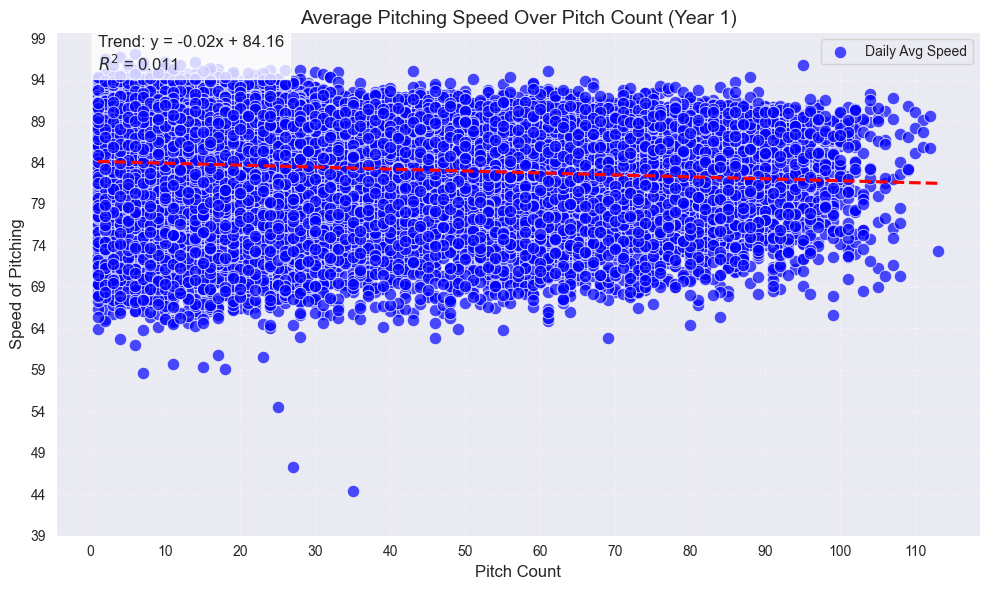

In [17]:
X = pitching_speed_df["pitch_count"]
y = pitching_speed_df["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pitching_speed_df, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=pitching_speed_df, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count (Year 1)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

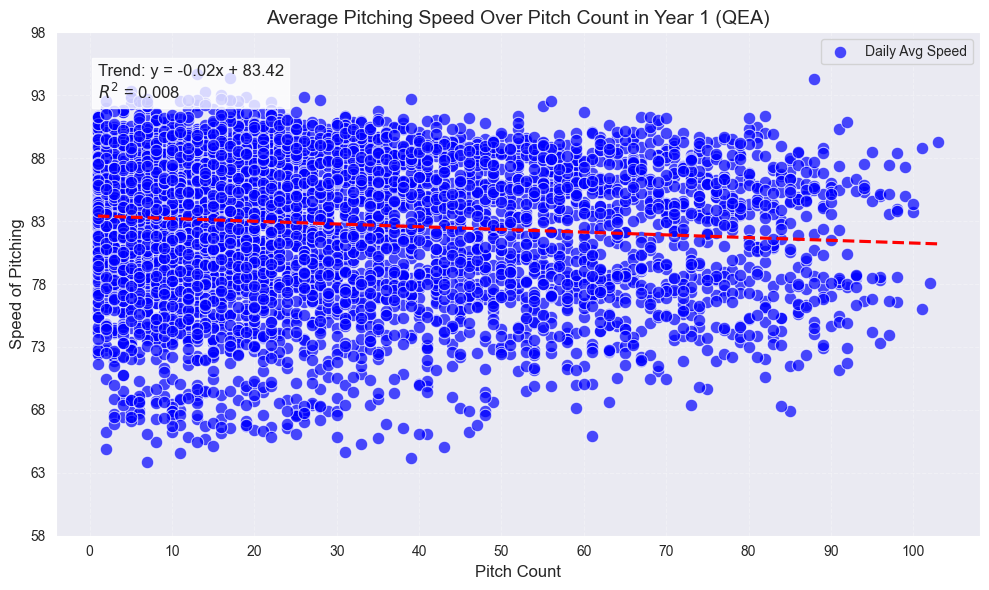

In [18]:
QEA_pitching = pitching_speed_df[pitching_speed_df['team_of_pitcher'] == 'QEA']

X = QEA_pitching["pitch_count"]
y = QEA_pitching["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=QEA_pitching, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=QEA_pitching, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count in Year 1 (QEA)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# not in year 2

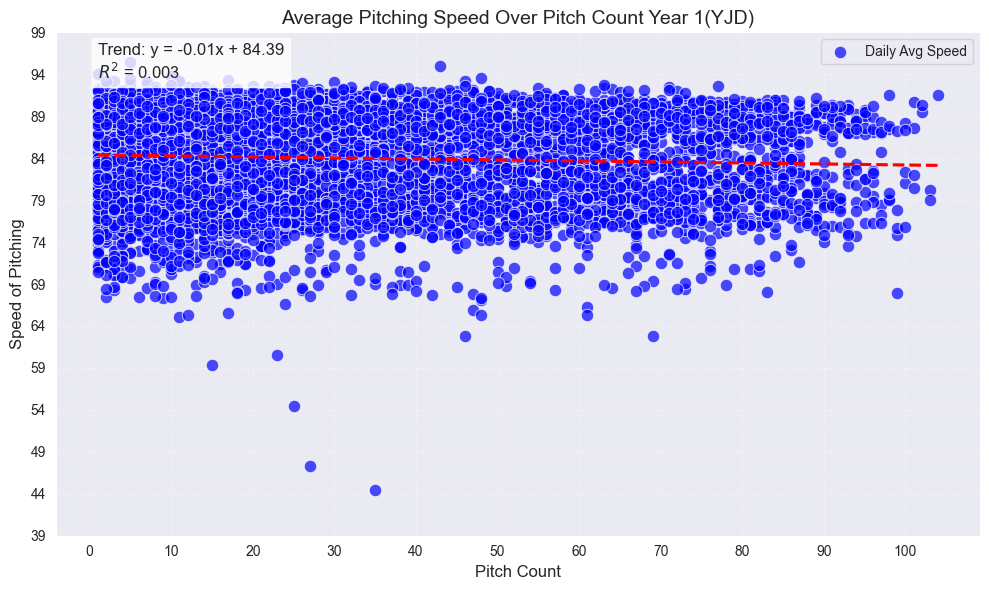

In [19]:
YJD_pitching = pitching_speed_df[pitching_speed_df['team_of_pitcher'] == 'YJD']

X = YJD_pitching["pitch_count"]
y = YJD_pitching["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=YJD_pitching, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=YJD_pitching, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count Year 1(YJD)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

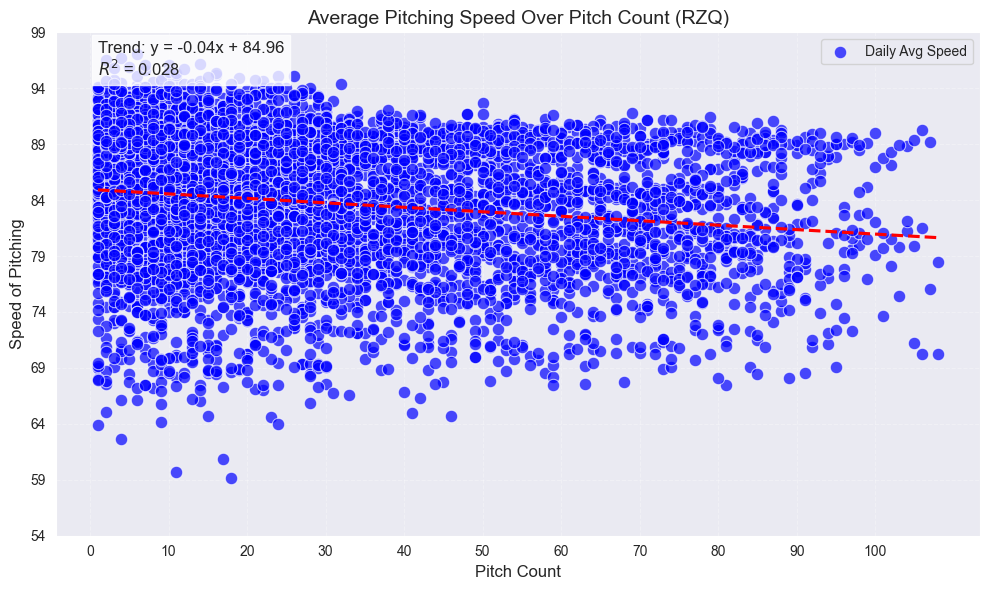

In [20]:
RZQ_pitching = pitching_speed_df[pitching_speed_df['team_of_pitcher'] == 'RZQ']

X = RZQ_pitching["pitch_count"]
y = RZQ_pitching["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RZQ_pitching, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=RZQ_pitching, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count (RZQ)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

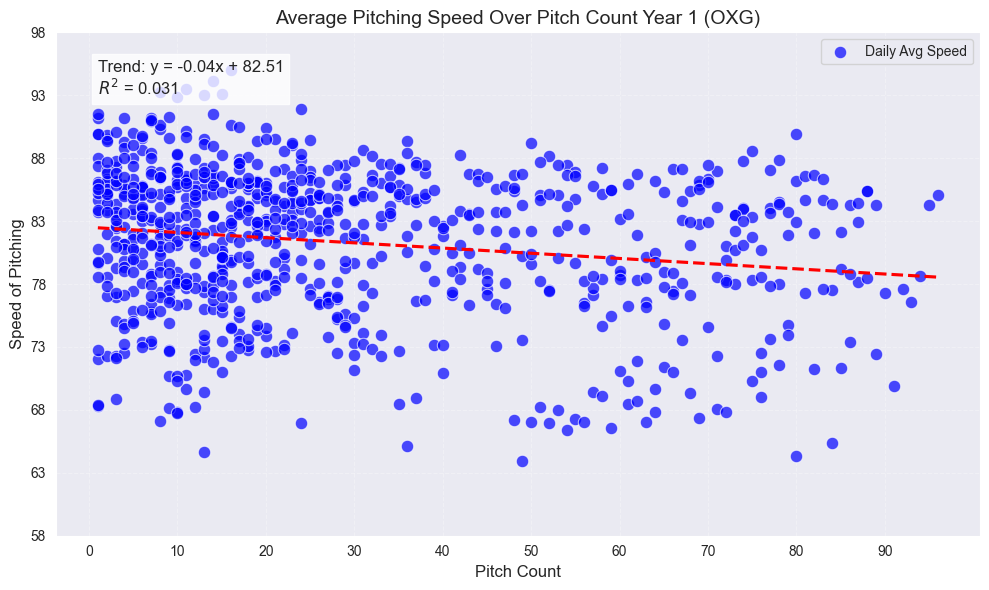

In [21]:
OXG_pitching = pitching_speed_df[pitching_speed_df['team_of_pitcher'] == 'OXG']

X = OXG_pitching["pitch_count"]
y = OXG_pitching["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=OXG_pitching, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=OXG_pitching, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count Year 1 (OXG)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# not seen in year 2

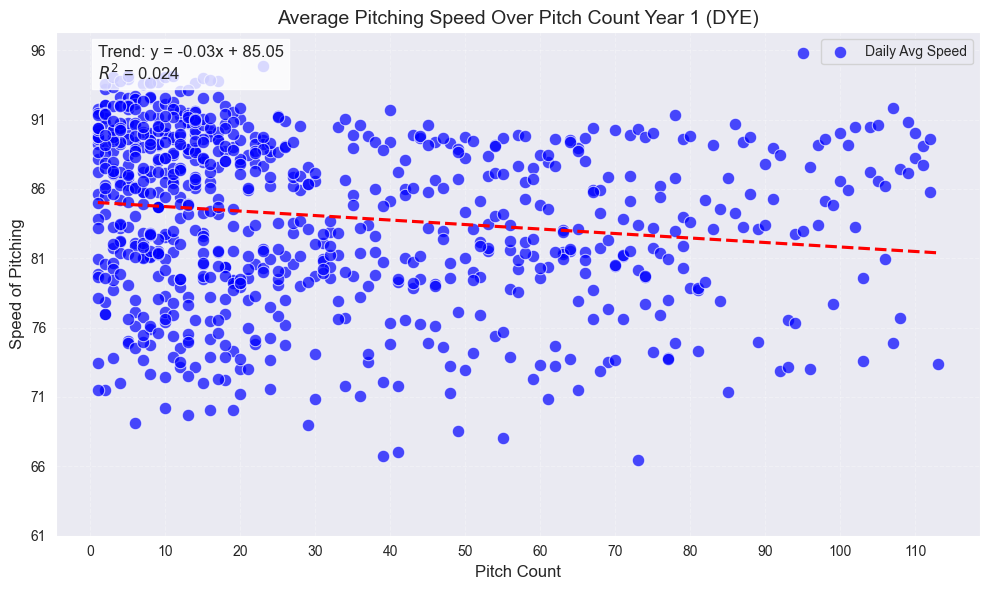

In [22]:
DYE_pitching = pitching_speed_df[pitching_speed_df['team_of_pitcher'] == 'DYE']

X = DYE_pitching["pitch_count"]
y = DYE_pitching["pitching_speed"]
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=DYE_pitching, x="pitch_count", y="pitching_speed", s=80, color='blue', alpha=0.7, label='Daily Avg Speed')
sns.regplot(data=DYE_pitching, x="pitch_count", y="pitching_speed",
            scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'label': 'Trend'}, ci=None)

# Annotations
equation_text = f"Trend: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}"
plt.text(x=X.min(), y=y.max()-2, s=equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.xticks(np.arange(0, X.max()+1, 10))  # Show every 10 days
plt.yticks(np.arange(int(y.min())-5, int(y.max())+5, 5))  # Custom y-axis range
plt.title("Average Pitching Speed Over Pitch Count Year 1 (DYE)".format(slope, r_squared), fontsize=14)
plt.xlabel("Pitch Count", fontsize=12)
plt.ylabel("Speed of Pitching", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Despite all of the teams showing a decrease in their pitching velocity of the pitching count become larger per game, ...

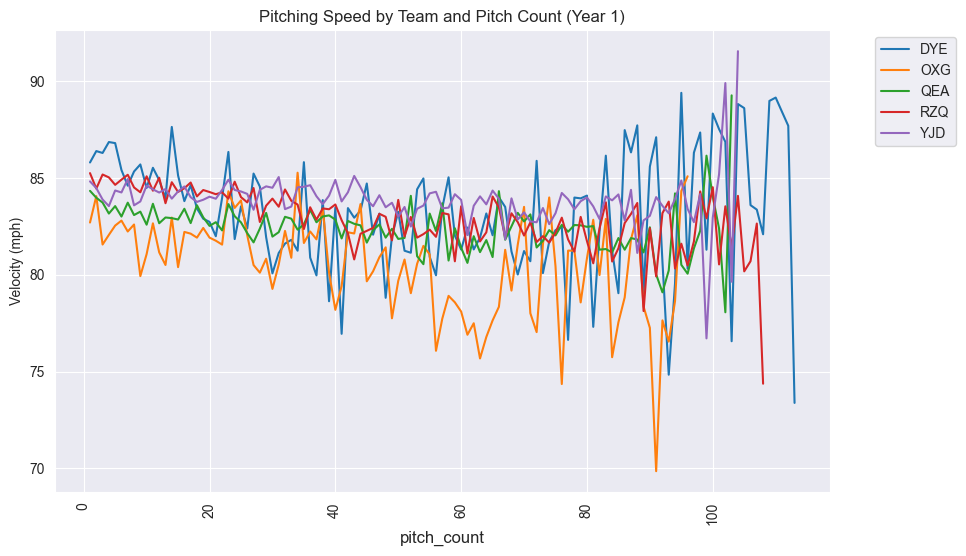

In [23]:
team_focus = ['DYE', 'OXG', 'QEA', 'RZQ', 'YJD']

# Filter rows where 'team_of_pitcher' is in team_focus
pitching_speed_df_focus = pitching_speed_df[
    pitching_speed_df['team_of_pitcher'].isin(team_focus)
]

team_velocity = pitching_speed_df_focus.groupby(['team_of_pitcher', 'pitch_count'])['pitching_speed'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(
    x='pitch_count',
    y='pitching_speed',
    data=team_velocity,
    hue='team_of_pitcher',
)
plt.legend(title='Team',bbox_to_anchor=(1.05, 1),loc='upper left',fontsize=8)
plt.xlabel('pitch_count', fontsize=12)
plt.ylabel('Velocity (mph)')
plt.title('Pitching Speed by Team and Pitch Count (Year 1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()


As shown in the graphs for "Pitching Speed by Team and Pitch Count", the teams (DYE, OXG, QEA, RZQ, YJD) show a trend in a decrease in speed as the pitch count increases. However, despite some of their pitches increasing as the pitch count increases, the deviation of the pitching speed increases as well. Seen in the graph are teams, including YJD, which reaches speeds as low as about 80 mph. This can show signs of fatigue when the pitch is late in the game. However, the pitchers can pitch at a slow speed to confuse the opposing batter. In regards to late in the game, team OXG shows the lowest decrease in velocity from pitch counts compared to before the increase in spread of the pitching speed around 80 pitches, the teams show a decrease in pitching speed, even reaching as low as 70 mph. Noticeably, DYE starts with a pitching velocity of about 86 mph. Later on, the team starts having a large decrease in pitching speed, reaching as low as 75 mph. Despite the possibility of OXG and DYE's pitchers using different types of pitches, such as screwballs or curveballs,


To further analyze the possibility of fatigue in pitchers, the project follows up with the use of a fatigue score. The fatigue score takes into account the velocity drop and pitch count in the game. To account for types of pitches thrown, the fatigue score will also be affected by the strength needed for the pitch. A study done by the American Orthopaedic Society for Sports Medicine displayed the use of elbow varus torque in different pitch types. The study showed that fastballs tend to produce the highest amount of elbow proximal force, followed by curveballs, sliders, and then change-ups. With the elbow varus torque producing tension in the ulnar collateral ligament (UCL), constant use of pitches with a high amount of elbow focus can lead to injury to the pitcher.

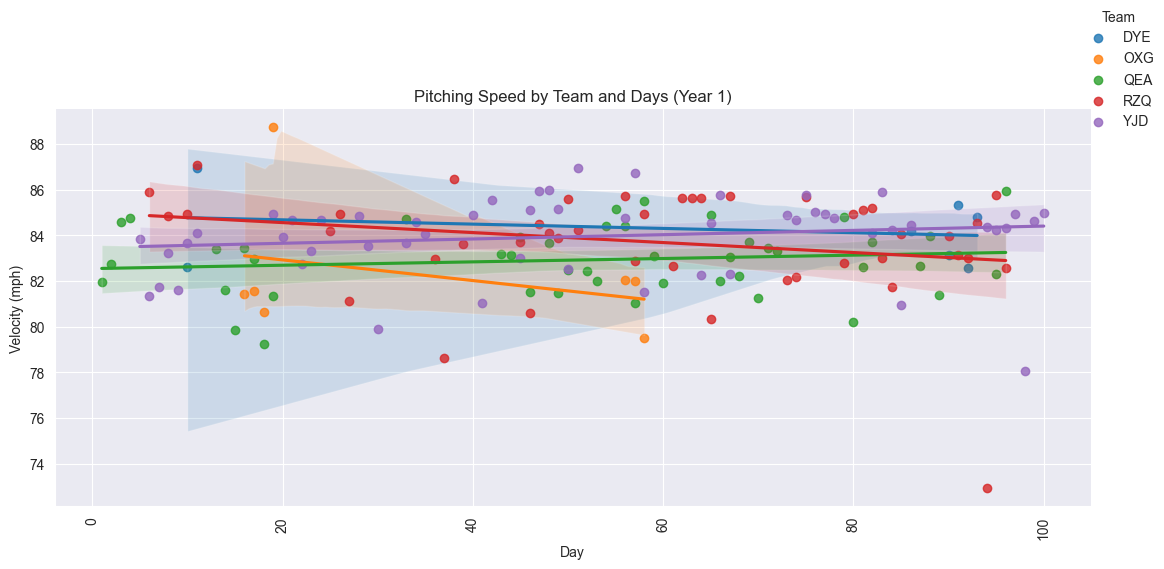

In [24]:
# Average pitching speed by day (Year 1)

average_pitching_speed = pitching_speed_df.groupby(['team_of_pitcher', 'day'])['pitching_speed'].mean().reset_index()
average_pitching_speed = average_pitching_speed[average_pitching_speed['team_of_pitcher'].isin(team_focus)]

g = sns.lmplot(
    x='day',
    y='pitching_speed',
    data=average_pitching_speed,
    hue='team_of_pitcher',
    height=5,
    aspect=2,
    legend=True
)

# Customize the existing legend
g._legend.set_title('Team', prop={'size': 10})
g._legend.set_bbox_to_anchor((1.05, 1))  # Position outside plot

# Axis labels and title
g.set(
    xlabel='Day',
    ylabel='Velocity (mph)',
    title='Pitching Speed by Team and Days (Year 1)'
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Measurement Fatigue in Teams (DYE, OXG, QEA, RZQ, YJD)

In [25]:
# Focusing by year
team_velocity = pitching_speed_df.groupby(['team_of_pitcher', 'pitch_count'])['pitching_speed'].mean().reset_index()

team_velocity = team_velocity[team_velocity['team_of_pitcher'].isin(team_focus)]



### Pitching Velocity (finding the pitching speed and where the ball is in the strike-zone)


In [26]:
def analyze_pitch_direction(df, batter_pos_x=-2.1867, batter_pos_y=-0.7866):
    # Sort by play_id and timestamp
    df = df.sort_values(by=['play_id', 'timestamp'])

    # Compute differences (dx, dy, dz)
    df['dx'] = df.groupby('play_id')['ball_position_x'].diff()
    df['dy'] = df.groupby('play_id')['ball_position_y'].diff()
    df['dz'] = df.groupby('play_id')['ball_position_z'].diff()

    # Compute direction vectors (unit vector)
    magnitude = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
    df['ux'] = df['dx'] / magnitude  # Normalized x-direction
    df['uy'] = df['dy'] / magnitude  # Normalized y-direction
    df['uz'] = df['dz'] / magnitude  # Normalized z-direction

    # Finding the angles
    df['azimuth'] = np.degrees(np.arctan2(df['dy'], df['dx']))  # Horizontal angle (-180° to 180°)
    df['elevation'] = np.degrees(np.arcsin(df['dz'] / magnitude))  # Vertical angle (-90° to 90°)

    # Projected crossing point at home plate (x = batter_pos_x)
    # Linear extrapolation: x_final = x_current + dx/dy * (batter_pos_y - y_current)
    df['projected_crossing_y'] = df['ball_position_y'] + (df['dy'] / df['dx']) * (batter_pos_x - df['ball_position_x'])
    df['projected_crossing_z'] = df['ball_position_z'] + (df['dz'] / df['dx']) * (batter_pos_x - df['ball_position_x'])

    # Is it inside the strike zone? (Assuming MLB strike zone: -0.85 < y < 0.85, 1.5 < z < 3.5)
    df['in_strike_zone'] = (df['projected_crossing_y'].abs() < 0.85) & (df['projected_crossing_z'] > 1.5) & (df['projected_crossing_z'] < 3.5)

    return df[['game_str','play_id', 'day','timestamp', 'ux', 'uy', 'uz', 'azimuth', 'elevation',
               'projected_crossing_y', 'projected_crossing_z', 'in_strike_zone']]

ball_direction = analyze_pitch_direction(ball_pos_df)


In [27]:
# merging pitching with ball direction
pitching_velocity = pitching_speed_df.merge(ball_direction, on=['game_str','timestamp'], how='left')
pitching_speed_df = pitching_speed_df[pitching_speed_df['event_code'] == 'pitch']
pitching_velocity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35610 entries, 0 to 35609
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   game_str               35610 non-null  object  
 1   pitch_sequence         35610 non-null  int64   
 2   initial_time           35610 non-null  float64 
 3   pitch_type             35610 non-null  object  
 4   year                   35610 non-null  int64   
 5   day_x                  35610 non-null  int64   
 6   away_team              35610 non-null  object  
 7   home_team              35610 non-null  object  
 8   play_per_game          35610 non-null  float64 
 9   timestamp              35610 non-null  int64   
 10  player_position        35610 non-null  category
 11  event_code             35610 non-null  category
 12  ball_position_x        35610 non-null  float64 
 13  ball_position_y        35610 non-null  float64 
 14  ball_position_z        35610 non-null 

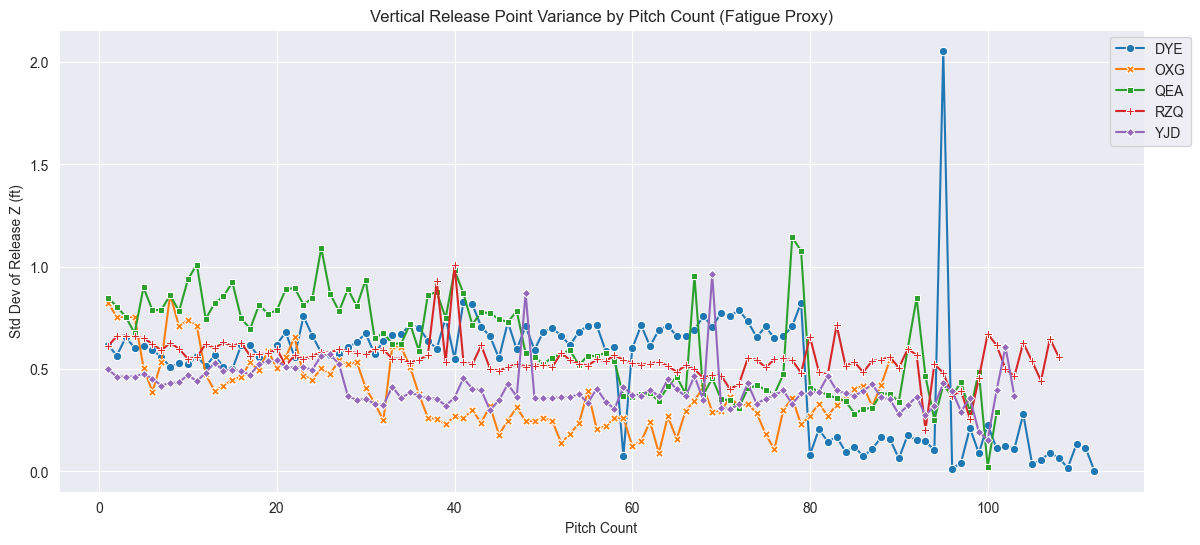

In [28]:
# Calculating release point variance per team per pitch count bin
temp = pitching_velocity[pitching_velocity['team_of_pitcher'].isin(team_focus)]
release_variance = temp.groupby(['team_of_pitcher', 'pitch_count'])[['ball_position_x', 'ball_position_y', 'ball_position_z']].std().reset_index()

# Plot release point consistency
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=release_variance,
    x='pitch_count',
    y='ball_position_z',
    hue='team_of_pitcher',
    style='team_of_pitcher',
    markers=True,
    dashes=False
)
plt.title('Vertical Release Point Variance by Pitch Count (Fatigue Proxy)')
plt.xlabel('Pitch Count')
plt.ylabel('Std Dev of Release Z (ft)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

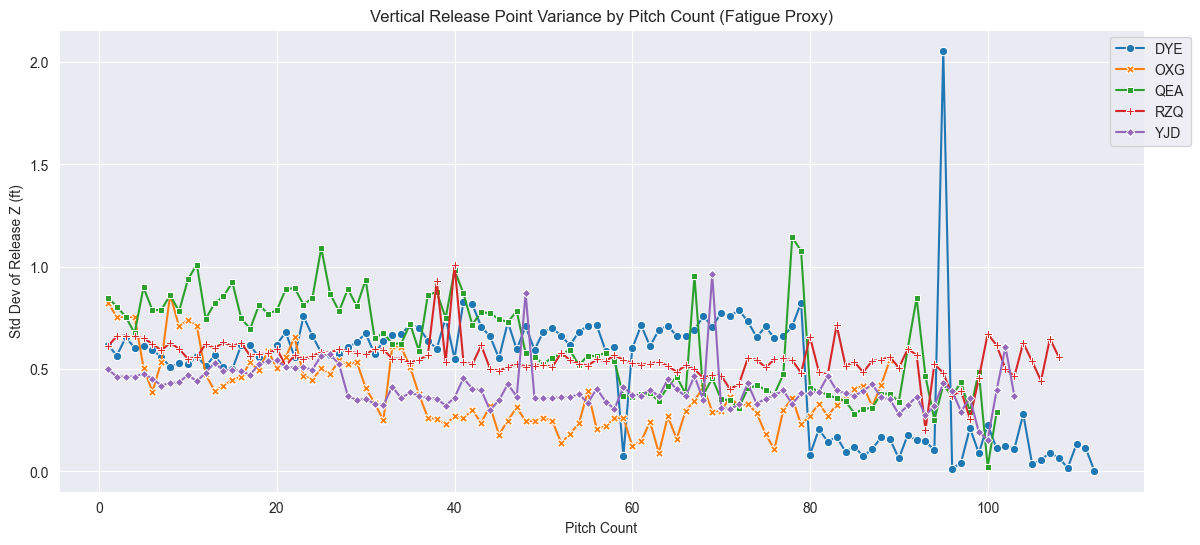

In [29]:
# Calculating release point variance per team per pitch count bin
temp = pitching_velocity[pitching_velocity['team_of_pitcher'].isin(team_focus)]
release_variance = temp.groupby(['team_of_pitcher', 'pitch_count'])[['ball_position_x', 'ball_position_y', 'ball_position_z']].std().reset_index()

# Plot release point consistency
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=release_variance,
    x='pitch_count',
    y='ball_position_z',
    hue='team_of_pitcher',
    style='team_of_pitcher',
    markers=True,
    dashes=False
)
plt.title('Vertical Release Point Variance by Pitch Count (Fatigue Proxy)')
plt.xlabel('Pitch Count')
plt.ylabel('Std Dev of Release Z (ft)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [30]:
# Finding frequency of pitching per pitcher
frequency_df = (pitching_speed_df.groupby(['pitcher',
                                          'day']).size()
                .reset_index(name='appearance_count'))
frequency_df['team'] = frequency_df['pitcher'].str.slice(0,3)

In [31]:
freq_w_teams = frequency_df[frequency_df['team'].isin(team_focus)]
grouped_freq_team = freq_w_teams.groupby('pitcher')['appearance_count'].sum()
grouped_freq_team = grouped_freq_team.reset_index()

grouped_freq_team['team'] = grouped_freq_team['pitcher'].str.slice(0,3)

average_by_category = grouped_freq_team.groupby('team')['appearance_count'].mean()
average_by_category

team
DYE     50.062500
OXG     43.473684
QEA    186.741935
RZQ    179.242424
YJD    248.178571
Name: appearance_count, dtype: float64

In [32]:
grouped_freq_team.groupby('team')['appearance_count'].max()

team
DYE    130
OXG    109
QEA    511
RZQ    722
YJD    752
Name: appearance_count, dtype: int64

In [33]:
grouped_freq_team.groupby('team')['appearance_count'].min()

team
DYE    10
OXG    11
QEA    10
RZQ     8
YJD     1
Name: appearance_count, dtype: int64

<Axes: xlabel='total_pitches', ylabel='team'>

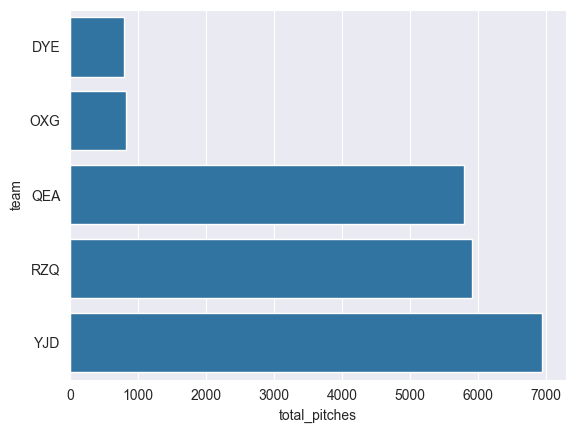

In [34]:
pitch_count = pitching_speed_df.groupby('pitcher').size().rename('total_pitches')
pitch_count = pitch_count.reset_index()
pitch_count['team'] = pitch_count['pitcher'].str.slice(0,3)
temp = pitch_count[pitch_count['team'].isin(team_focus)]
temp = temp.groupby('team')['total_pitches'].sum()

grouped_freq_team = pd.merge(grouped_freq_team, temp, on='team', how = 'outer')
grouped_freq_team['pitches_per_appearance'] = grouped_freq_team['total_pitches'] / grouped_freq_team['appearance_count']

sns.barplot(grouped_freq_team, x="total_pitches", y="team")


/var/folders/70/58_fmkvx1rv29ckl5tw1vyb00000gn/T/ipykernel_4399/588196227.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_workload, x='team', y='pitches_per_pitcher', palette='Blues')


Text(0, 0.5, 'Pitches/Pitcher')

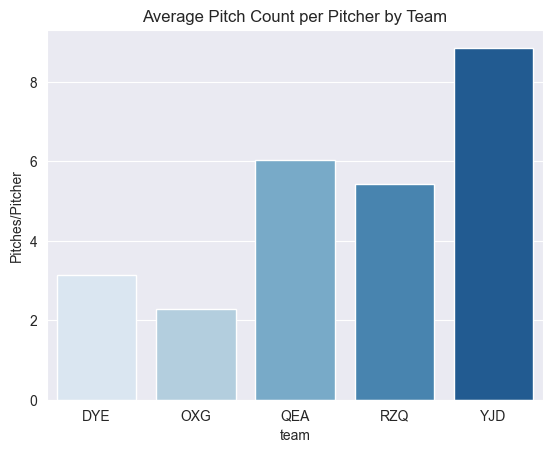

In [35]:
# Add pitcher count per team
pitcher_counts = pitch_count.groupby('team')['pitcher'].nunique()

# Calculate pitches per pitcher
team_workload = average_by_category.reset_index()
team_workload['pitchers'] = team_workload['team'].map(pitcher_counts)
team_workload['pitches_per_pitcher'] = team_workload['appearance_count'] / team_workload['pitchers']

# Plot
sns.barplot(data=team_workload, x='team', y='pitches_per_pitcher', palette='Blues')
plt.title('Average Pitch Count per Pitcher by Team')
plt.ylabel('Pitches/Pitcher')

In [36]:
# pitches by day count
pitches_count_day = pitching_speed_df.groupby(['day', 'pitcher']).size().rename('total_pitches')

pitching_speed_df = pd.merge(pitching_speed_df, pitches_count_day, on=['day', 'pitcher'], how='right')

In [37]:
# Calculate max speed per pitcher per day (aligned with original DataFrame)
pitching_speed_df['max_speed'] = pitching_speed_df.groupby(['day', 'pitcher'])['pitching_speed'].transform('max')

# Now you can calculate velocity drop
pitching_speed_df['velo_drop'] = pitching_speed_df['max_speed'] - pitching_speed_df['pitching_speed']

In [38]:
pitching_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35610 entries, 0 to 35609
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   game_str               35610 non-null  object  
 1   pitch_sequence         35610 non-null  int64   
 2   initial_time           35610 non-null  float64 
 3   pitch_type             35610 non-null  object  
 4   year                   35610 non-null  int64   
 5   day                    35610 non-null  int64   
 6   away_team              35610 non-null  object  
 7   home_team              35610 non-null  object  
 8   play_per_game          35610 non-null  float64 
 9   timestamp              35610 non-null  int64   
 10  player_position        35610 non-null  category
 11  event_code             35610 non-null  category
 12  ball_position_x        35610 non-null  float64 
 13  ball_position_y        35610 non-null  float64 
 14  ball_position_z        35610 non-null 

## FATIGUE SCORE
Using pitch count, velocity drop, and directon (z) to measure the potential amount of fatigue in a player

In [39]:
fatigue_multipliers = {
    'fast_ball': 1.2,
    'slider': 1.1,
    'curveball': 1.1,
    'changeup': 0.9}

In [40]:
# FATIGUE SCORE
pitching_speed_df['pitch_count_per'] = (pitching_speed_df['pitch_count'] / pitching_speed_df['total_pitches']) * 100
pitching_speed_df['velo_drop_per'] = (1 - (pitching_speed_df['pitching_speed'] / pitching_speed_df['max_speed'])) * 100
pitching_speed_df['fatigue_score'] = pitching_speed_df['velo_drop_per'] * 0.35 + pitching_speed_df['pitch_count_per'] * 0.40

pitching_speed_df['fatigue_score'] *= pitching_speed_df['pitch_type'].map(fatigue_multipliers)

In [41]:
pitching_speed_df['fatigue_score'].head(10)

0     6.616466
1     5.647059
2     9.066144
3    14.156220
4    16.378690
5    16.989826
6    20.030868
7    22.716983
8    25.691136
9    28.290021
Name: fatigue_score, dtype: float64

In [42]:
# Removing error found
pitching_speed_df = pitching_speed_df.drop(index = 1337)

In [43]:
pitching_speed_df['fatigue_score'].describe()

count    35608.000000
mean        26.265076
std         13.425413
min          0.648685
25%         14.805370
50%         26.328161
75%         37.798779
max         54.897989
Name: fatigue_score, dtype: float64

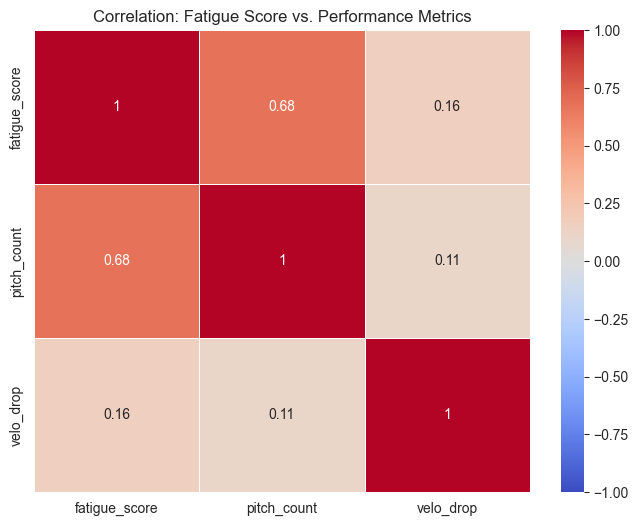

In [44]:
# Calculate correlations
corr_matrix = pitching_speed_df[['fatigue_score', 'pitch_count', 'velo_drop']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('Correlation: Fatigue Score vs. Performance Metrics')
plt.show()

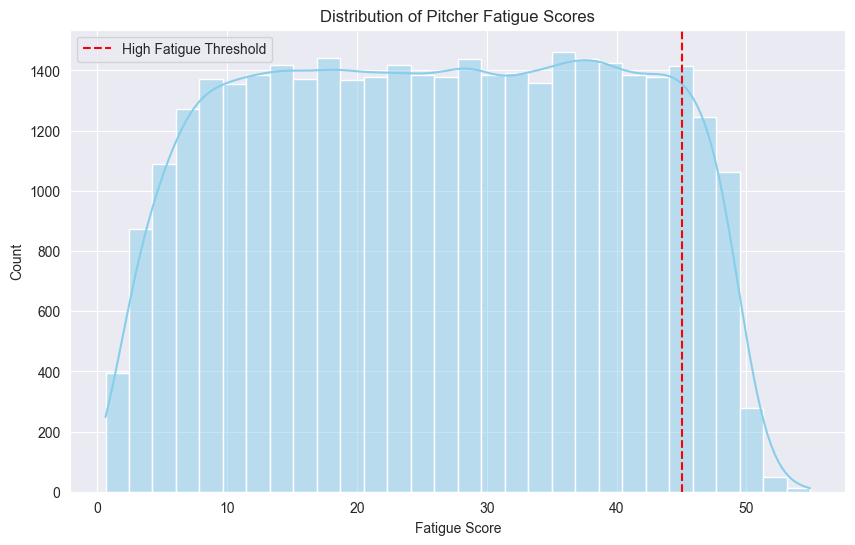

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(pitching_speed_df['fatigue_score'], bins=30, kde=True, color='skyblue')
plt.axvline(x=45, color='red', linestyle='--', label='High Fatigue Threshold')
plt.title('Distribution of Pitcher Fatigue Scores')
plt.xlabel('Fatigue Score')
plt.ylabel('Count')
plt.legend()
plt.show()

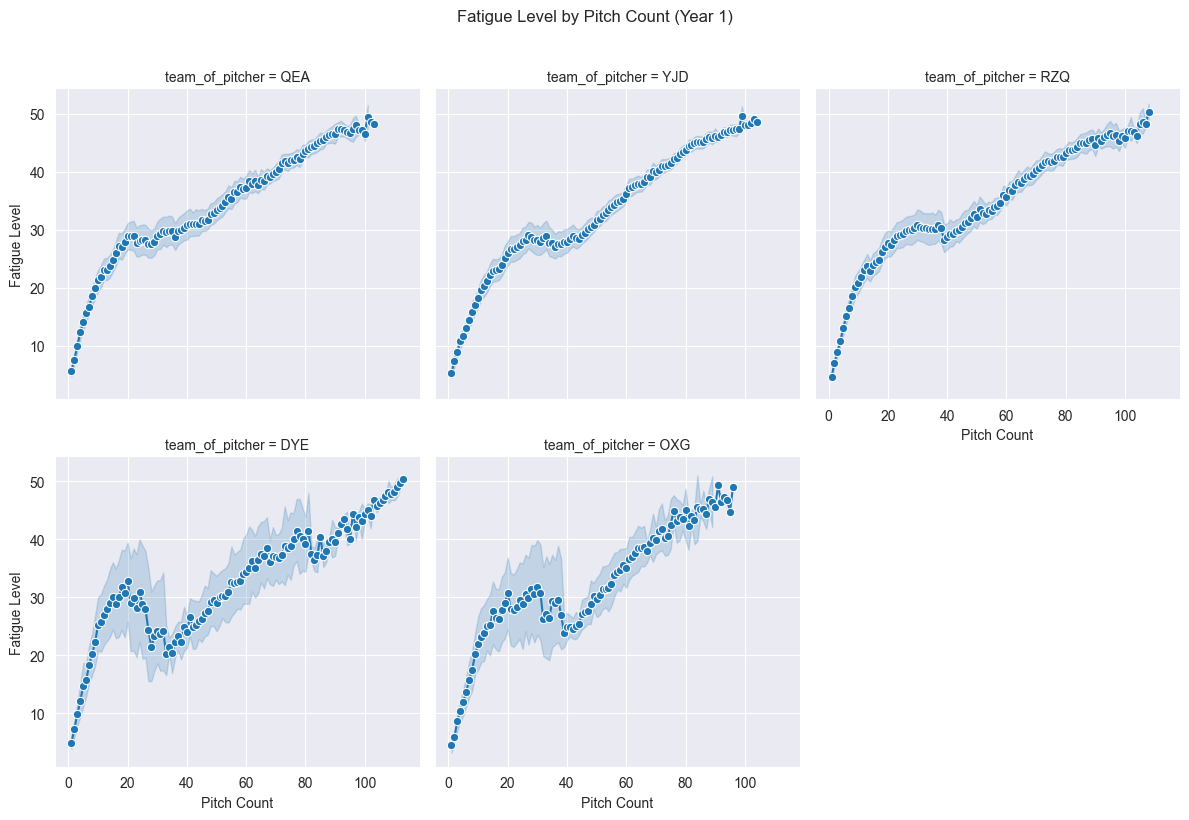

In [46]:
# UPDATED: Filter rows where 'team_of_pitcher' is in team_focus
pitching_speed_df_focus = pitching_speed_df[
    pitching_speed_df['team_of_pitcher'].isin(team_focus)
]

g = sns.FacetGrid(pitching_speed_df_focus, col='team_of_pitcher', col_wrap=3, height=4)
g.map(sns.lineplot, 'pitch_count', 'fatigue_score', marker='o')
g.set_axis_labels("Pitch Count", "Fatigue Level")
g.fig.suptitle("Fatigue Level by Pitch Count (Year 1)", y=1.02)
plt.tight_layout()
plt.show()


/var/folders/70/58_fmkvx1rv29ckl5tw1vyb00000gn/T/ipykernel_4399/873449182.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


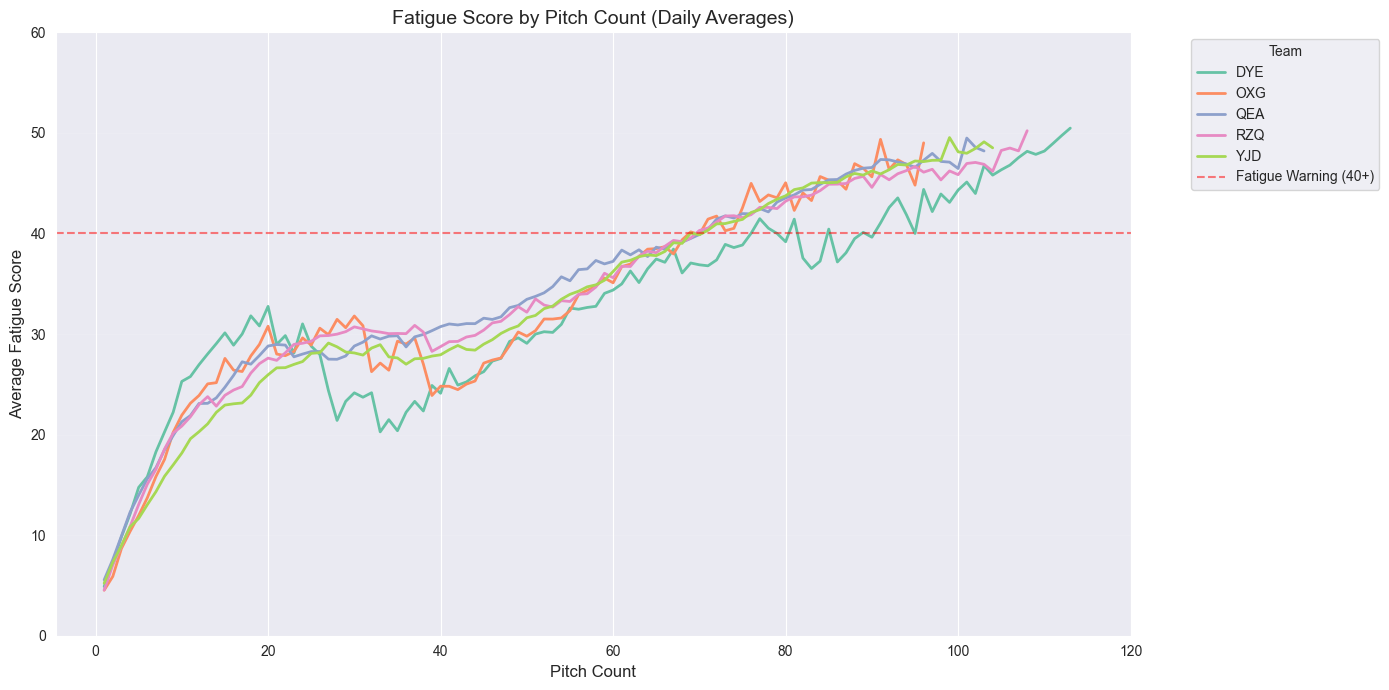

In [47]:
plt.figure(figsize=(14, 7))
pitching_speed_focus = pitching_speed_df[pitching_speed_df['team_of_pitcher'].isin(team_focus)]

# Group by team and pitch count (averaging across days)
fatigue_by_pitchcount = (
    pitching_speed_focus.groupby(['team_of_pitcher', 'pitch_count'])
    ['fatigue_score'].mean()
    .reset_index()
)

ax = sns.lineplot(
    data=fatigue_by_pitchcount,
    x='pitch_count',
    y='fatigue_score',
    hue='team_of_pitcher',
    palette='Set2',
    linewidth=2,
    ci=None
)

plt.axhline(y=40, color='red', linestyle='--', alpha=0.5, label='Fatigue Warning (40+)')

plt.title('Fatigue Score by Pitch Count (Daily Averages)', fontsize=14)
plt.xlabel('Pitch Count', fontsize=12)
plt.ylabel('Average Fatigue Score', fontsize=12)
plt.xticks(range(0, 121, 20))
plt.yticks(range(0, 101, 10))
plt.legend(title='Team', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', alpha=0.1)
plt.ylim(0, 60)
plt.tight_layout()
plt.show()

/var/folders/70/58_fmkvx1rv29ckl5tw1vyb00000gn/T/ipykernel_4399/3888165187.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


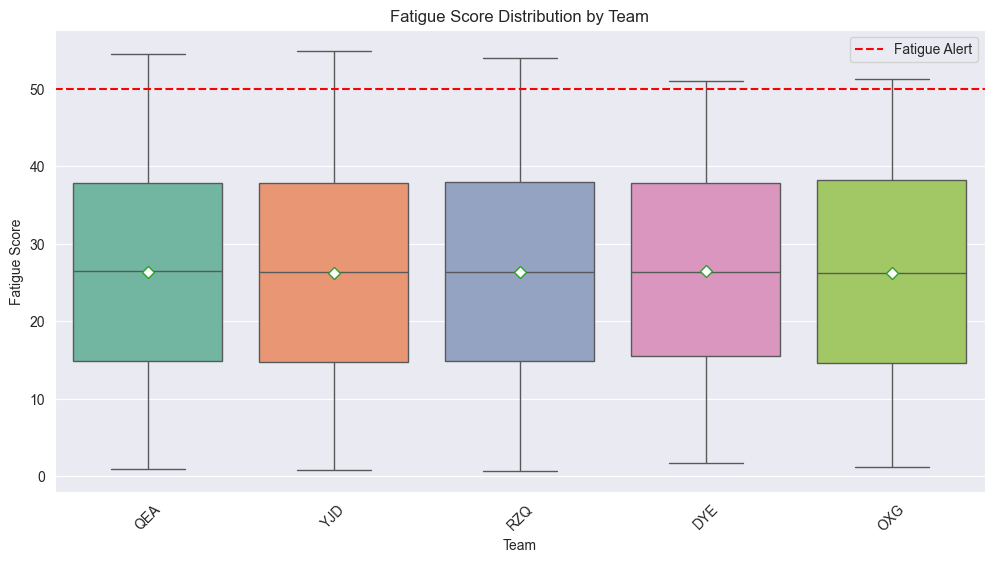

In [48]:
pitching_speed_focus = pitching_speed_df[pitching_speed_df['team_of_pitcher'].isin(team_focus)]
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pitching_speed_focus,
    x='team_of_pitcher',
    y='fatigue_score',
    palette='Set2',
    showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'white'}
)
plt.axhline(y=50, color='red', linestyle='--', label='Fatigue Alert')
plt.title('Fatigue Score Distribution by Team')
plt.xlabel('Team')
plt.ylabel('Fatigue Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Finding Teams with Above Average Fatigue Levels

In [49]:
mean_fatigue = (pitching_speed_df.groupby('team_of_pitcher')['fatigue_score'].mean()).mean()
#pitching_speed_df[pitching_speed_df['fatigue_score'] > mean_fatigue]
mean_fatigue

np.float64(26.270303108049827)

In [50]:
temp = pitching_speed_df[pitching_speed_df['fatigue_score'] > mean_fatigue]
temp['team_of_pitcher'].unique()

array(['CGA', 'QEA', 'JJS', 'YJD', 'RZQ', 'MCJ', 'GEA', 'DYE', 'IXC',
       'OXG', 'JFU', 'AKX', 'JIL', 'CMS', 'AVV', 'REC', 'HMN', 'TKJ',
       'WJU', 'MHY', 'VHS', 'STK', 'UPU', 'JZK', 'APZ', 'KJH', 'WZR',
       'JNJ', 'HCI', 'IAQ', 'UEX', 'OWH', 'ACN', 'PHS', 'UWE', 'GAX',
       'FBP', 'PVJ', 'CRQ', 'KQQ', 'WNA', 'XAX', 'MRJ'], dtype=object)

In [51]:
pitching_type_count = pitching_speed_df.groupby('team_of_pitcher')["pitch_type"].value_counts()
pitching_type_count = pitching_type_count.reset_index()

# fix the proportion
team_appearance = (pitching_speed_df.groupby(['team_of_pitcher']).size()
                .reset_index(name='appearance_count'))
pitching_type_count = pd.merge(pitching_type_count,team_appearance, on='team_of_pitcher', how='left')
pitching_type_count['frequency_prop'] = pitching_type_count['count'] / pitching_type_count['appearance_count']

In [52]:
# Teams that average above the fatigue levels
high_fatigue_teams = pitching_speed_df.groupby('team_of_pitcher')['fatigue_score'].mean() > mean_fatigue
high_fatigue_teams = high_fatigue_teams[high_fatigue_teams]
print(high_fatigue_teams)

team_of_pitcher
AVV    True
CGA    True
CMS    True
CRQ    True
DYE    True
GAX    True
GEA    True
JFU    True
JJS    True
JZK    True
KJH    True
MCJ    True
QEA    True
REC    True
RZQ    True
STK    True
UEX    True
UPU    True
VHS    True
WNA    True
Name: fatigue_score, dtype: bool


In [53]:
fatigue_teams = pitching_speed_df.groupby('team_of_pitcher')['fatigue_score'].mean()
high_fatigue_teams = pd.merge(high_fatigue_teams,fatigue_teams, on='team_of_pitcher', how='left')

In [54]:
high_fatigue_teams

,fatigue_score_x,fatigue_score_y
team_of_pitcher,,
AVV,True,26.697935
CGA,True,26.721945
CMS,True,27.123922
CRQ,True,26.343022
DYE,True,26.524764
GAX,True,26.607678
GEA,True,26.634136
JFU,True,26.378245
JJS,True,26.310309


In [55]:
columns_to_drop = ['fatigue_score_x']
high_fatigue_teams = high_fatigue_teams.rename(columns = {'fatigue_score_y':'fatigue_score'})
high_fatigue_teams = high_fatigue_teams.drop(columns = columns_to_drop)
high_fatigue_teams

,fatigue_score
team_of_pitcher,
AVV,26.697935
CGA,26.721945
CMS,27.123922
CRQ,26.343022
DYE,26.524764
GAX,26.607678
GEA,26.634136
JFU,26.378245
JJS,26.310309


In [56]:
high_fatigue_teams = high_fatigue_teams.reset_index()
high_fatigue_teams

,team_of_pitcher,fatigue_score
0,AVV,26.697935
1,CGA,26.721945
2,CMS,27.123922
3,CRQ,26.343022
4,DYE,26.524764
5,GAX,26.607678
6,GEA,26.634136
7,JFU,26.378245
8,JJS,26.310309
9,JZK,26.343662


In [57]:
high_fatigue_teams_list = high_fatigue_teams['team_of_pitcher'].tolist()

/var/folders/70/58_fmkvx1rv29ckl5tw1vyb00000gn/T/ipykernel_4399/640114884.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=high_fatigue_teams, y='team_of_pitcher', x='fatigue_score', palette='viridis', saturation=0.8, edgecolor='black', linewidth=0.5)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'AVV'),
  Text(0, 1, 'CGA'),
  Text(0, 2, 'CMS'),
  Text(0, 3, 'CRQ'),
  Text(0, 4, 'DYE'),
  Text(0, 5, 'GAX'),
  Text(0, 6, 'GEA'),
  Text(0, 7, 'JFU'),
  Text(0, 8, 'JJS'),
  Text(0, 9, 'JZK'),
  Text(0, 10, 'KJH'),
  Text(0, 11, 'MCJ'),
  Text(0, 12, 'QEA'),
  Text(0, 13, 'REC'),
  Text(0, 14, 'RZQ'),
  Text(0, 15, 'STK'),
  Text(0, 16, 'UEX'),
  Text(0, 17, 'UPU'),
  Text(0, 18, 'VHS'),
  Text(0, 19, 'WNA')])

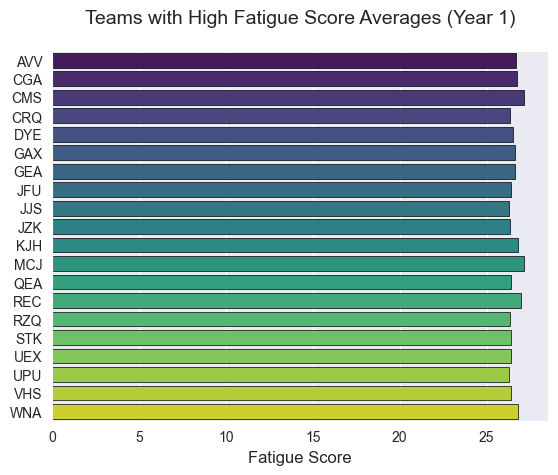

In [58]:
ax = sns.barplot(data=high_fatigue_teams, y='team_of_pitcher', x='fatigue_score', palette='viridis', saturation=0.8, edgecolor='black', linewidth=0.5)

plt.title('Teams with High Fatigue Score Averages (Year 1)', pad=20, fontsize=14)
plt.xlabel('Fatigue Score', fontsize=12)
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [59]:
low_fatigue_teams = pitching_speed_df.groupby('team_of_pitcher')['fatigue_score'].mean() < mean_fatigue
low_fatigue_teams = low_fatigue_teams[low_fatigue_teams]

low_fatigue_teams = pd.merge(low_fatigue_teams,fatigue_teams, on='team_of_pitcher', how='left')

low_fatigue_teams = low_fatigue_teams.rename(columns = {'fatigue_score_y':'fatigue_score'})
low_fatigue_teams = low_fatigue_teams.drop(columns = "fatigue_score_x")


In [60]:
low_fatigue_teams = low_fatigue_teams.reset_index()

In [61]:
low_fatigue_teams

,team_of_pitcher,fatigue_score
0,ACN,25.746783
1,AKX,26.204963
2,APZ,26.121539
3,FBP,26.172413
4,HCI,25.919806
5,HMN,25.842864
6,IAQ,26.025106
7,IXC,26.206909
8,JIL,25.891683
9,JNJ,26.115139


In [62]:
# Run t-test (equal_var=False if variances differ)
t_stat, p_val = stats.ttest_ind(high_fatigue_teams['fatigue_score'],
                                low_fatigue_teams['fatigue_score'],
                                equal_var=True)

print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

t-statistic: 7.962, p-value: 0.0000


## Type of Pitch Proportion for Teams with High and Below Avg. Fatigue Score

In [63]:
pitch_type_count_high_fat = pitching_type_count[pitching_type_count['team_of_pitcher'].isin(high_fatigue_teams_list)]

In [64]:
pitch_type_count_low_fat = pitching_type_count[~pitching_type_count['team_of_pitcher'].isin(high_fatigue_teams_list)]

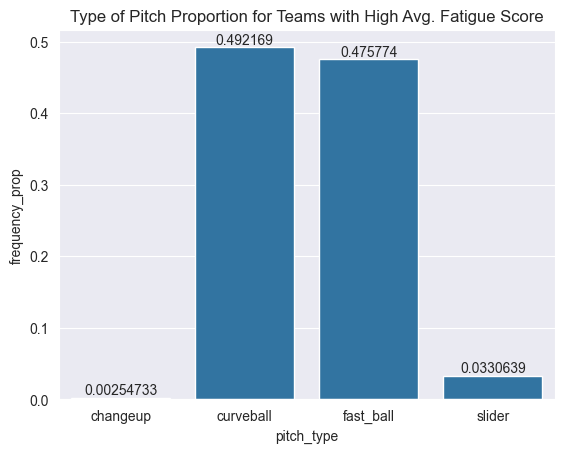

In [65]:
pitch_type_count_high_fat = pitch_type_count_high_fat[pitch_type_count_high_fat['pitch_type']!= 'unknown']

ax = sns.barplot(pitch_type_count_high_fat.groupby('pitch_type')['frequency_prop'].mean())
ax.set_title("Type of Pitch Proportion for Teams with High Avg. Fatigue Score")
ax.bar_label(ax.containers[0], fontsize=10);

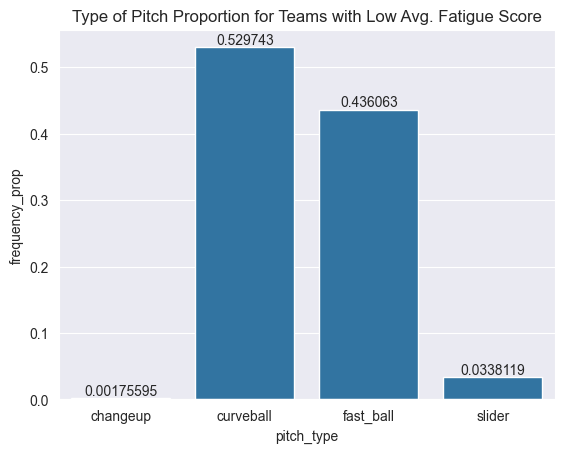

In [66]:
pitch_type_count_low_fat = pitching_type_count[~pitching_type_count['team_of_pitcher'].isin(high_fatigue_teams_list)]
ax = sns.barplot(pitch_type_count_low_fat.groupby('pitch_type')['frequency_prop'].mean())
ax.set_title("Type of Pitch Proportion for Teams with Low Avg. Fatigue Score")
ax.bar_label(ax.containers[0], fontsize=10);

In [67]:
ind_pitcher_fatigue = pitching_speed_df.groupby('pitcher')['fatigue_score'].mean()
ind_pitcher_fatigue = ind_pitcher_fatigue.reset_index()
ind_pitcher_fatigue['team'] = ind_pitcher_fatigue['pitcher'].str.slice(0,3)
ind_pitcher_fatigue_mean = ind_pitcher_fatigue['fatigue_score'].mean()

above_pitcher_fatigue = ind_pitcher_fatigue[ind_pitcher_fatigue['fatigue_score'] > ind_pitcher_fatigue_mean]


In [68]:
above_pitcher_fatigue_count = above_pitcher_fatigue['team'].value_counts()
above_pitcher_fatigue_count = above_pitcher_fatigue_count.reset_index()

In [69]:
ind_pitcher_fatigue = ind_pitcher_fatigue['team'].value_counts()
ind_pitcher_fatigue = ind_pitcher_fatigue.reset_index()
ind_pitcher_fatigue.head()

,team,count
0,RZQ,33
1,QEA,31
2,YJD,28
3,OXG,19
4,DYE,16


In [70]:
# roster_size_of_pitchers
roster_size_of_pitchers_raw = pitching_speed_df.groupby('team_of_pitcher')['pitcher'].unique()
roster_size_of_pitchers = roster_size_of_pitchers_raw.map(len)
roster_size_of_pitchers = roster_size_of_pitchers.reset_index()
roster_size_of_pitchers = roster_size_of_pitchers.rename(columns = {'pitcher':'roster_size','team_of_pitcher':'team'})

In [71]:
pitcher_fatigue_prop = pd.merge(above_pitcher_fatigue_count,roster_size_of_pitchers, on = "team", how='outer')
pitcher_fatigue_prop['fatigue_prop'] = pitcher_fatigue_prop['count'] / pitcher_fatigue_prop['roster_size']
fatigue_prop_mean = pitcher_fatigue_prop['fatigue_prop'].mean()
high_fatigue_prop = pitcher_fatigue_prop[pitcher_fatigue_prop['fatigue_prop'] > fatigue_prop_mean]
high_fatigue_prop = high_fatigue_prop.reset_index()
high_fatigue_prop = high_fatigue_prop.drop(['index','count','roster_size'], axis=1)
high_fatigue_prop = high_fatigue_prop[high_fatigue_prop['fatigue_prop'] != 1]
high_fatigue_prop

,team,fatigue_prop
0,AVV,0.500000
1,CGA,0.500000
2,CMS,0.750000
3,DYE,0.625000
4,GEA,0.625000
5,IXC,0.555556
6,JFU,0.500000
7,JNJ,0.500000
8,JZK,0.500000
9,KJH,0.818182


/var/folders/70/58_fmkvx1rv29ckl5tw1vyb00000gn/T/ipykernel_4399/2655395.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=high_fatigue_prop, y='team', x='fatigue_prop', palette='viridis', saturation=0.8, edgecolor='black', linewidth=0.5)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'AVV'),
  Text(0, 1, 'CGA'),
  Text(0, 2, 'CMS'),
  Text(0, 3, 'DYE'),
  Text(0, 4, 'GEA'),
  Text(0, 5, 'IXC'),
  Text(0, 6, 'JFU'),
  Text(0, 7, 'JNJ'),
  Text(0, 8, 'JZK'),
  Text(0, 9, 'KJH'),
  Text(0, 10, 'PHS'),
  Text(0, 11, 'QEA'),
  Text(0, 12, 'STK'),
  Text(0, 13, 'VHS')])

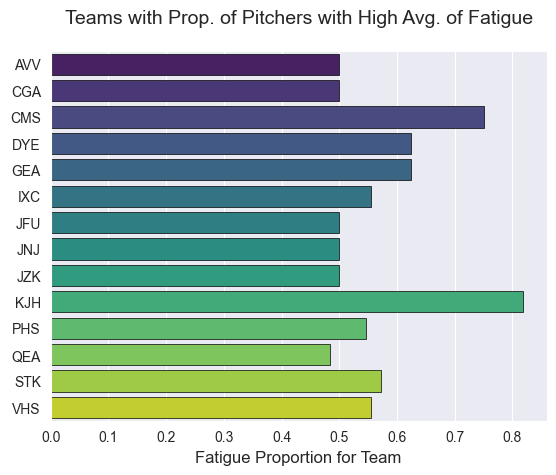

In [72]:
ax = sns.barplot(data=high_fatigue_prop, y='team', x='fatigue_prop', palette='viridis', saturation=0.8, edgecolor='black', linewidth=0.5)

plt.title('Teams with Prop. of Pitchers with High Avg. of Fatigue', pad=20, fontsize=14)
plt.xlabel('Fatigue Proportion for Team', fontsize=12)
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Saving CSV files

In [73]:
pitching_speed_raw.to_csv('pitching_speed_raw.csv', index=False)
ball_direction.to_csv('ball_direction.csv', index=False)
pitching_speed_df.to_csv('pitching_speed.csv', index=False)
high_fatigue_teams.to_csv('high_fatigue_teams.csv', index=False)
low_fatigue_teams.to_csv('low_fatigue_teams.csv', index=False)

